# Database 

In [1]:
# Import functions and models
from functions import *
from models import *

# Set seed
set_seed(2020)

Using TensorFlow backend.


Firsly, the dataset is read using Pandas. The file is supposed to be located in ```../dataset/```.

In [2]:
# Column names
col_names = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]
# Reading dataset
dataset = pd.read_csv('../dataset/wdbc.data', header=None, names= col_names)

Display the first 5 rows of the dataset.

In [3]:
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We separate the diagnosys column and drop the identifier (non-predictive variable).

In [4]:
X = dataset.drop(['id','diagnosis'], axis=1)
y = dataset['diagnosis']

We shown the number of Benign and Malign samples.

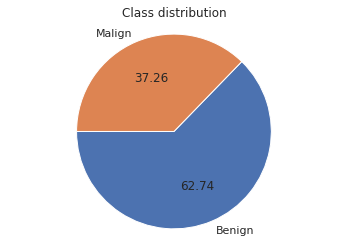

In [5]:
print_class_pie_diagram(y, ["Benign", "Malign"], "../tex/images/breast_proportion.pdf")

# Constants

In [6]:
# Hidden space dimensionality
hidden_space_dim = 2
# Ammount of samples
n_samples = X.shape[0]
# Observed space dimensionality
observed_space_dim = X.shape[1]
# Ammount of classes
n_classes = len(y.unique())
# Hidden layer dimension for Non-linear PCA and VAE
hidden_layer_dim = 100
# Training epochs
num_epochs = 4000
# Learning rate for Adam optimizer
learning_rate = 0.01

# Reduction to 2-dimensional space

## Probabilistic PCA

The data is generated supposing both the hidden representation and the transformation is generated using standard Gaussian distributions:
$$
Z \sim \mathcal{N}_{hidden\_space\_dim}(0,I), \quad W \sim \mathcal{N}_{hidden\_space\_dim \times observed\_space\_dim}(0, I).
$$
$$
\delta \sim \mathcal{N}_{observed\_space\_dim}(0,I)
$$
The observed data follows a Gaussian distribution with parameters
$$
X \mid z, w, \delta \sim \mathcal{N}_{observed\_space\_dim}(w^T z + \delta, I).
$$

In [7]:
# create an instance of the P model and the Q model
pca_model = pca(hidden_space_dim, observed_space_dim)
pca_q = Q_pca(hidden_space_dim, observed_space_dim)

# Define optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
# Define inference object
VI_pca = inf.inference.VI(pca_q, optimizer=optimizer, epochs=num_epochs)

We fit the model using the dataset ```X```.

In [8]:
pca_model.fit({"x": X}, VI_pca)        


 0 epochs	 477782272.0....................
 200 epochs	 462470496.0....................
 400 epochs	 419453408.0....................
 600 epochs	 346626624.0....................
 800 epochs	 277949664.0....................
 1000 epochs	 186022048.0....................
 1200 epochs	 147834976.0....................
 1400 epochs	 111433416.0....................
 1600 epochs	 80090600.0....................
 1800 epochs	 58477696.0....................
 2000 epochs	 45903360.0....................
 2200 epochs	 35261600.0....................
 2400 epochs	 28842502.0....................
 2600 epochs	 19312652.0....................
 2800 epochs	 16170541.0....................
 3000 epochs	 12222683.0....................
 3200 epochs	 9921686.0....................
 3400 epochs	 8758350.0....................
 3600 epochs	 7476099.5....................
 3800 epochs	 5820792.5....................

The evolution of the loss function over the training is:

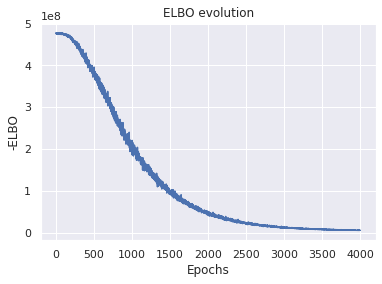

In [9]:
print_loss_function(VI_pca)

We plot the posterior using the learned model and the data.

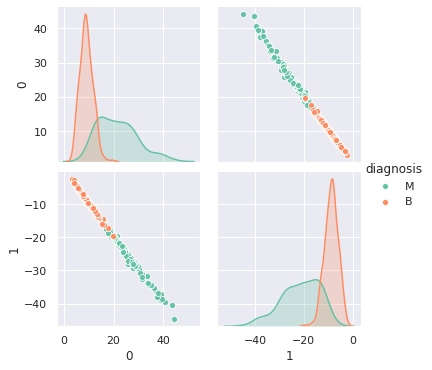

In [10]:
z = pca_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

We can obtain the transformation by taking the posterior distribution of ```w```.

In [11]:
post = pca_model.posterior("w").parameters()
print("Loc:", post["loc"])
print("Scale:", post["scale"])

Loc: [[ 3.01423073e-01  4.32832152e-01  3.00624251e+00  2.30130501e+01
  -4.75122622e-04 -8.20010668e-04  4.26907651e-03 -5.50186820e-03
  -1.78170635e-03 -3.11094685e-03  1.73095874e-02  1.41753070e-02
   1.10514276e-01  1.80915105e+00 -2.05402775e-03 -1.12505443e-03
  -6.78383233e-03 -7.37972418e-03 -6.66469755e-03  4.43341630e-03
   4.31725025e-01  7.09120691e-01  3.48655772e+00  3.20550308e+01
   4.74654313e-04 -1.37383630e-03  2.23905733e-03 -6.54676580e-04
   5.80856111e-03 -7.30798440e-03]
 [-1.61549240e-01  1.31857261e-01 -1.92069125e+00 -2.29730511e+01
  -4.01443010e-03 -9.12101124e-04 -5.49001293e-03 -2.73501850e-04
  -1.09527167e-03 -9.83417965e-04 -5.08607225e-03  1.05537958e-02
  -6.96532503e-02 -2.18505073e+00  7.05420226e-03 -1.73482997e-03
   8.49934854e-03  2.31475290e-03 -4.40099655e-04 -1.27193285e-03
  -2.14910507e-01  1.59450293e-01 -2.65164542e+00 -3.20980949e+01
  -2.96738697e-03 -6.85876468e-03 -2.63292412e-03 -1.45201362e-03
  -7.23842881e-04  4.26199753e-03]]


### Test Separability

We train an SVM to learn the dataset before and after applying the reduction, scores are shown below.

In [12]:
test_separability(X,z,y)

SVM score in observed space: 0.9226713532513181
SVM score in hidden space: 0.9068541300527241


## Non-linear PCA

The data is generated supposing the hidden representation is generated using standard Gaussian distributions:
$$
Z \sim \mathcal{N}_{hidden\_space\_dim}(0,I).
$$
A two layer network is used using standard Gaussian distribution for $\alpha_0, \alpha_1, \beta_0$ and $\beta_1$ as:
$$
f(z) = (relu(z^T \beta_0 + \alpha_0))^T\beta_1 + \alpha_1.
$$
The observed data follows a Gaussian distribution using $f$ for its mean value:
$$
X \mid z \sim \mathcal{N}_{observed\_space\_dim}(f(z), I).
$$

In [13]:
# create an instance of the P model and the Q model
nlpca_model = nlpca(hidden_space_dim, hidden_layer_dim, observed_space_dim)
nlpca_q = Q_nlpca(hidden_space_dim, hidden_layer_dim, observed_space_dim)

# Define optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
# Define inference object
VI_nlpca = inf.inference.VI(nlpca_q, optimizer=optimizer, epochs=num_epochs)

Fit the model

In [14]:
nlpca_model.fit({"x": X}, VI_nlpca)        


 0 epochs	 498272352.0....................
 200 epochs	 192278048.0....................
 400 epochs	 98301864.0....................
 600 epochs	 78787568.0....................
 800 epochs	 60029128.0....................
 1000 epochs	 58871184.0....................
 1200 epochs	 52130176.0....................
 1400 epochs	 56838868.0....................
 1600 epochs	 59527740.0....................
 1800 epochs	 52667664.0....................
 2000 epochs	 53341472.0....................
 2200 epochs	 55119308.0....................
 2400 epochs	 46716452.0....................
 2600 epochs	 41991764.0....................
 2800 epochs	 36398648.0....................
 3000 epochs	 41776272.0....................
 3200 epochs	 34811420.0....................
 3400 epochs	 25401636.0....................
 3600 epochs	 30800714.0....................
 3800 epochs	 25282444.0....................

Print loss function

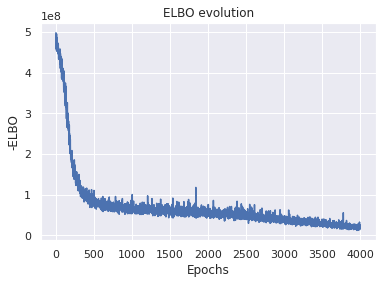

In [15]:
print_loss_function(VI_nlpca)

Print posterior sample.

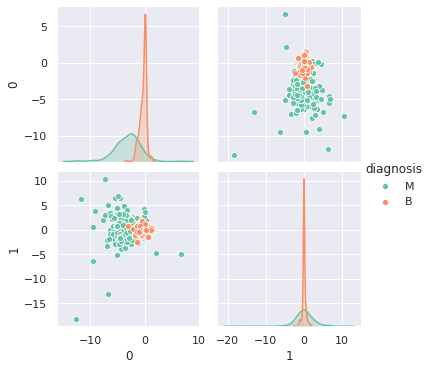

In [17]:
z = nlpca_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

### Test Separability

In [18]:
test_separability(X,z,y)

SVM score in observed space: 0.9226713532513181
SVM score in hidden space: 0.9121265377855887


## Variational auto-encoder

The data is generated supposing the hidden representation is generated using standard Gaussian distributions:
$$
Z \sim \mathcal{N}_{hidden\_space\_dim}(0,I).
$$
A two layer network is used for the observed data's mean value:
$$
X \mid z \sim \mathcal{N}_{observed\_space\_dim}(f(z), I).
$$

On the other hand, the variational distribution supposes the observed representation is generated using standard Gaussian distributions:
$$
X \sim \mathcal{N}_{observed\_space\_dim}(0,I).
$$
A two layer network is used for the hidden data's mean value:
$$
Z \mid x \sim \mathcal{N}_{observed\_space\_dim}(g(z), I).
$$

In [19]:
vae_model = vae(hidden_space_dim, hidden_layer_dim, observed_space_dim)
q_vae = Q_vae(hidden_space_dim , hidden_layer_dim, observed_space_dim)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI_vae = inf.inference.VI(q_vae, optimizer=optimizer, epochs=num_epochs)

Fit model

In [20]:
vae_model.fit({"x": X}, VI_vae)


 0 epochs	 478448000.0....................
 200 epochs	 5308625.0....................
 400 epochs	 2662257.25....................
 600 epochs	 2173707.75....................
 800 epochs	 1391168.25....................
 1000 epochs	 1126360.875....................
 1200 epochs	 923592.5....................
 1400 epochs	 803775.75....................
 1600 epochs	 2750708.5....................
 1800 epochs	 666393.25....................
 2000 epochs	 592803.4375....................
 2200 epochs	 577086.375....................
 2400 epochs	 519410.53125....................
 2600 epochs	 489107.625....................
 2800 epochs	 438276.65625....................
 3000 epochs	 397224.21875....................
 3200 epochs	 374394.96875....................
 3400 epochs	 345438.3125....................
 3600 epochs	 330803.21875....................
 3800 epochs	 552535.0625....................

Print loss function

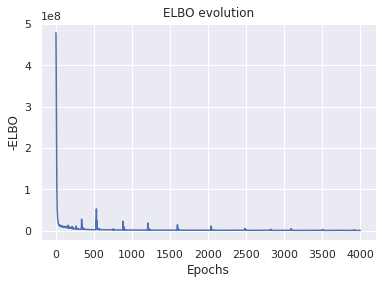

In [21]:
print_loss_function(VI_vae)

Print posterior sample 

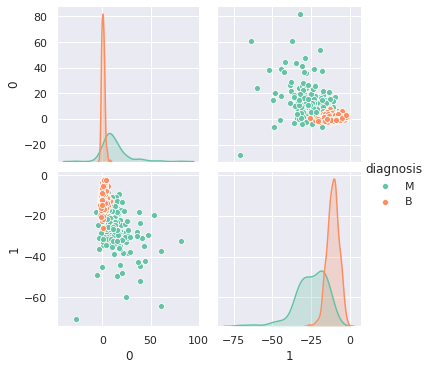

In [22]:
z = vae_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

### Test Separability


In [23]:
test_separability(X,z,y)

SVM score in observed space: 0.9226713532513181
SVM score in hidden space: 0.9349736379613357


# Reduction to 3-dimensional space

We set the hidden space to be 3-dimensional.

In [24]:
hidden_space_dim = 3

## Probabilistic PCA

In [25]:
# create an instance of the P model and the Q model
pca_model = pca(hidden_space_dim, observed_space_dim)
pca_q = Q_pca(hidden_space_dim, observed_space_dim)

# Define optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
# Define inference object
VI_pca = inf.inference.VI(pca_q, optimizer=optimizer, epochs=num_epochs)
# Training
pca_model.fit({"x": X}, VI_pca)        


 0 epochs	 476967232.0....................
 200 epochs	 470840992.0....................
 400 epochs	 387422816.0....................
 600 epochs	 305786400.0....................
 800 epochs	 214851760.0....................
 1000 epochs	 146258880.0....................
 1200 epochs	 97248160.0....................
 1400 epochs	 65888944.0....................
 1600 epochs	 44706540.0....................
 1800 epochs	 30660940.0....................
 2000 epochs	 23372574.0....................
 2200 epochs	 17189188.0....................
 2400 epochs	 12449648.0....................
 2600 epochs	 9559948.0....................
 2800 epochs	 8549165.0....................
 3000 epochs	 6821311.5....................
 3200 epochs	 5573892.5....................
 3400 epochs	 5630355.5....................
 3600 epochs	 4478061.5....................
 3800 epochs	 4226139.0....................

Print posterior sample.

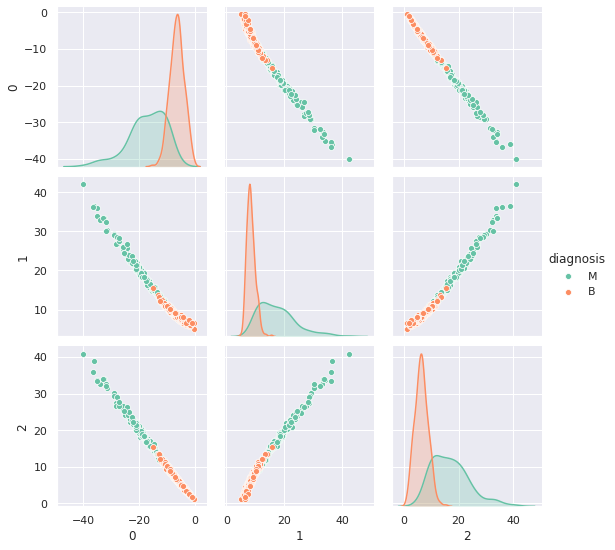

In [26]:
z = pca_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

Test separability

In [27]:
test_separability(X,z,y)

SVM score in observed space: 0.9226713532513181
SVM score in hidden space: 0.9103690685413005


## Non-linear PCA

In [28]:
# create an instance of the P model and the Q model
nlpca_model = nlpca(hidden_space_dim, hidden_layer_dim, observed_space_dim)
nlpca_q = Q_nlpca(hidden_space_dim, hidden_layer_dim, observed_space_dim)

# Define optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
# Define inference object
VI_nlpca = inf.inference.VI(nlpca_q, optimizer=optimizer, epochs=num_epochs)
# Training
nlpca_model.fit({"x": X}, VI_nlpca)


 0 epochs	 484584768.0....................
 200 epochs	 183529376.0....................
 400 epochs	 77256928.0....................
 600 epochs	 59459776.0....................
 800 epochs	 70715584.0....................
 1000 epochs	 55385668.0....................
 1200 epochs	 49967372.0....................
 1400 epochs	 45430892.0....................
 1600 epochs	 44040212.0....................
 1800 epochs	 54232560.0....................
 2000 epochs	 39847476.0....................
 2200 epochs	 41327776.0....................
 2400 epochs	 46658900.0....................
 2600 epochs	 33646524.0....................
 2800 epochs	 32297398.0....................
 3000 epochs	 28647022.0....................
 3200 epochs	 28414376.0....................
 3400 epochs	 26683462.0....................
 3600 epochs	 20863424.0....................
 3800 epochs	 17464408.0....................

Print posterior sample

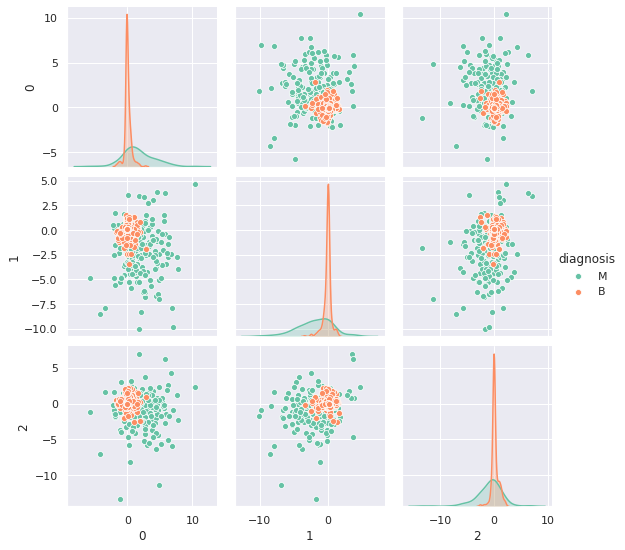

In [29]:
z = nlpca_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

In [30]:
test_separability(X,z,y)

SVM score in observed space: 0.9226713532513181
SVM score in hidden space: 0.9121265377855887


## Variational auto-encoder

In [31]:
vae_model = vae(hidden_space_dim, hidden_layer_dim, observed_space_dim)
q_vae = Q_vae(hidden_space_dim , hidden_layer_dim, observed_space_dim)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI_vae = inf.inference.VI(q_vae, optimizer=optimizer, epochs=num_epochs)
vae_model.fit({"x": X}, VI_vae)


 0 epochs	 448395808.0....................
 200 epochs	 4600297.5....................
 400 epochs	 2359082.0....................
 600 epochs	 5330998.5....................
 800 epochs	 1196065.125....................
 1000 epochs	 921914.5625....................
 1200 epochs	 843351.25....................
 1400 epochs	 614678.625....................
 1600 epochs	 593473.25....................
 1800 epochs	 746447.0....................
 2000 epochs	 429241.125....................
 2200 epochs	 407629.90625....................
 2400 epochs	 3905470.0....................
 2600 epochs	 322297.5....................
 2800 epochs	 301974.75....................
 3000 epochs	 272225.09375....................
 3200 epochs	 255431.796875....................
 3400 epochs	 239685.828125....................
 3600 epochs	 227219.90625....................
 3800 epochs	 212772.125....................

Print posterior sample

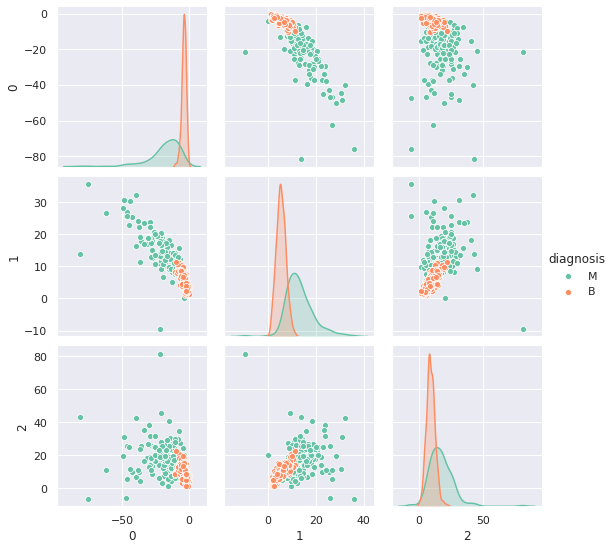

In [32]:
z = vae_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

In [33]:
test_separability(X,z,y)

SVM score in observed space: 0.9226713532513181
SVM score in hidden space: 0.9209138840070299
